In [23]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for data preparation and model building
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for model building
from sklearn.model_selection import train_test_split
import tensorflow as tf
import scipy.sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [24]:
train = pd.read_csv('https://raw.githubusercontent.com/thembani47/Natural-Language-Processing-with-Disaster-Tweets/main/Data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/thembani47/Natural-Language-Processing-with-Disaster-Tweets/main/Data/test.csv')


In [25]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [27]:
test.shape

(3263, 4)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [29]:
train.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [30]:
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [31]:
train = train.drop(['location','keyword'], axis=1)
test = test.drop(['location','keyword'], axis=1)

In [32]:
train['target'].unique()

array([1, 0], dtype=int64)

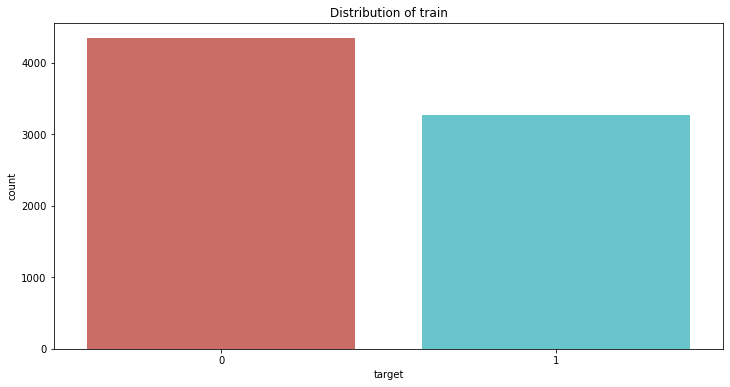

In [33]:
# A sentiment bar graph plot 
plt.figure (figsize= (12,6))
sns.countplot(x = 'target', data = train, palette="hls")
plt.title("Distribution of train");

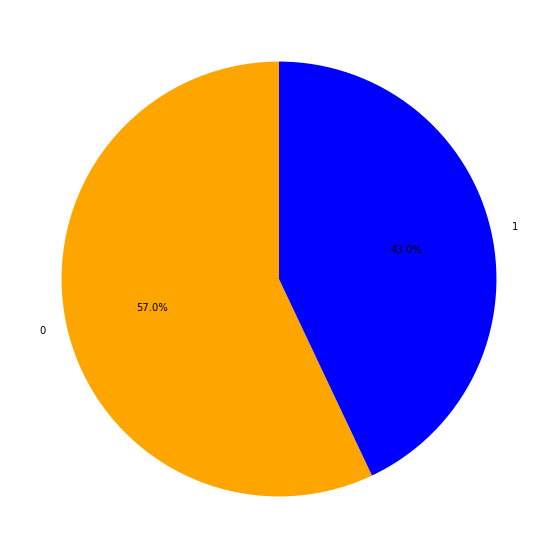

In [34]:
plt.figure (figsize= (16,10))
values = train['target'].value_counts()/train.shape[0]
labels = (train['target'].value_counts()/train.shape[0]).index
colors = ['orange', 'blue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.show()

In [35]:
train[train['text'].map(lambda x: x.isascii())]
test[test['text'].map(lambda x: x.isascii())]

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3257,10858,The death toll in a #IS-suicide car bombing on...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [36]:
for x in train['text'][30:150]:
    print(x)

The end!
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
Crying out for more! Set me ablaze
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Ablaze for you Lord :D
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
on the outside you're ablaze and alive
but you're dead inside
Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??
SOOOO PUMPED FOR ABLAZE ???? @s

In [37]:
# Removing duplicates of Train set. There are few duplicates in Test set as well,
# however, duplicates of Test set can'b be removed because the final test with target has to be uploaded as a submission file

train = train.drop_duplicates(subset=['text'], keep='last')
print("Shape of Train set after removing duplicates:", train.shape)

Shape of Train set after removing duplicates: (7503, 3)


In [38]:
def clean_tweets(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text)    # Removing @mentions
    text = re.sub(r'#','',text)                 # Removing #tag symbol
    text = re.sub(r'RT[\s]+',' ',text)          # Remvoing RT
    text = re.sub(r'\n','',text) 
    text = re.sub(r',','',text) 
    text = re.sub(r'.[.]+','',text) 
    text = re.sub(r'\w+:\/\/\S+','',text) 
    text = re.sub(r'https?:\/\/\S+','',text)    # Removing hyperlinks
    text = re.sub(r'/',' ',text)
    text = re.sub(r'-',' ',text)
    text = re.sub(r'_',' ',text)
    text = re.sub(r'!','',text)
    text = re.sub(r':',' ',text)
    text = re.sub(r'$','',text)
    text = re.sub(r'%','',text)
    text = re.sub(r'^','',text)
    text = re.sub(r'&','',text)
    text = re.sub(r'=',' ',text)
    text = re.sub(r' +',' ',text)               # Removing extra whitespaces

    return text

# Removing Emojis
def clean_emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

train['text'] = train['text'].apply(clean_tweets)    # Applying function to clean tweets
train['text'] = train['text'].apply(clean_emoji)     # Applying function to remove emojis
train['text'] = train.text.str.lower()               # Making all texts to lower case
train['text'] = train['text'].str.strip()            # Removing leading and trailing whitespaces

test['text'] = test['text'].apply(clean_tweets)      # Applying function to clean tweets
test['text'] = test['text'].apply(clean_emoji)       # Applying function to remove emojis
test['text'] = test.text.str.lower()                 # Making all texts to lower case
test['text'] = test['text'].str.strip()              # Removing leading and trailing whitespaces

In [39]:
train['target'].value_counts()

0    4307
1    3196
Name: target, dtype: int64

In [40]:
# Creating a df that is copy of the train set.
df = train.copy()

In [41]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

In [43]:
# Splitting data into Train and Test sets:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

In [44]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  62381


In [45]:
# Creating a list of all the models to train
models = [
          LogisticRegression(random_state = 5),
          SVC(),
          MultinomialNB(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(max_depth=6),
          #xgb.XGBClassifier()
         ]

In [46]:
%%time
# Fitting models onto the training data and predicting.
for model in range(0, len(models)):
    # define a pipeline to be nested and combined with other sklearn objects
    pipe = Pipeline([('clf', models[model])])

    # train the models
    pipe.fit(X_train, y_train)  
    predictions = pipe.predict(X_test)
    
    # display the results
    print(models[model])
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),2))
    print('****\t****\t****\t****\t****\t****\t****\t****\t****\t****\t****\t****\t****')

LogisticRegression(random_state=5)
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       843
           1       0.83      0.67      0.74       658

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.79      1501
weighted avg       0.80      0.80      0.79      1501

F1_score:  0.79
****	****	****	****	****	****	****	****	****	****	****	****	****
SVC()
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       843
           1       0.86      0.64      0.73       658

    accuracy                           0.79      1501
   macro avg       0.81      0.78      0.78      1501
weighted avg       0.80      0.79      0.79      1501

F1_score:  0.79
****	****	****	****	****	****	****	****	****	****	****	****	****
MultinomialNB()
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       843
           1      

In [48]:
testx = test['text'] #also transform x_test
test_vect = vectoriser.transform(testx)

In [49]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(test_vect)

#print("Best HyperParameter: ", gsv.best_params_)

In [52]:
svc_pred.shape

(3263,)

In [59]:
test['target'] = svc_pred

In [60]:
test.head()

,id,text,sentiment,target
0,0,just happened a terrible car crash,1,1
1,2,heard about earthquake is different cities sta...,0,0
2,3,there is a forest fire at spot pond geese are ...,1,1
3,9,apocalypse lightin spokane wildfires,0,0
4,11,typhoon soudelor kills 28 in china and taiwan,1,1


In [61]:
test[['id','target']].to_csv('testsubmission.csv', index=False) # create csv file that is align with compitition format